## Clustering World Happiness Report 2019

In [4]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats.mstats import winsorize
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [5]:
# import dataset
df=pd.read_csv("2019.csv")

In [6]:
# Take a glipmse of the data
df.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,Finland,1.340,1.587,0.986,0.596,0.153,0.393
1,Denmark,1.383,1.573,0.996,0.592,0.252,0.410
2,Norway,1.488,1.582,1.028,0.603,0.271,0.341
3,Iceland,1.380,1.624,1.026,0.591,0.354,0.118
4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298


## Exploratory Data Analysis


#### First I want to check for outliers. Boxplots are a good visualisation choice to detect outliers.

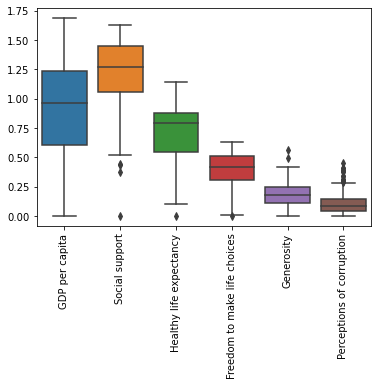

In [7]:
p=sns.boxplot(data=df.loc[:, ['GDP per capita', 'Social support',
                           "Healthy life expectancy",
                           "Freedom to make life choices",
                           "Generosity",
                           "Perceptions of corruption"]])

p.tick_params(axis='x', rotation=90);

#### We can see that some variables have outliers. For some of the variables the outliers are below the bottom whisker whereas for others they are above the top whisker

## Use Winsorise to impute values for outliers

#### Let's first impute the values for variables whose outliers lie below the bottom whisker. I impute the values for the bottom 3% of the distribution

In [8]:
col_names_1=df.columns[2:5].to_list()

for i in range(0,len(col_names_1)):
    df[col_names_1[i]]=winsorize(df[col_names_1[i]],limits=[0.03,0])

#### Now I impute values for the variables whose outliers lie above the top whisker. I impute the values for the top 10% of the distribution

In [9]:
col_names_2=df.columns[5:7].to_list()

for i in range(0,len(col_names_2)):
    df[col_names_2[i]]=winsorize(df[col_names_2[i]],limits=[0,0.1])

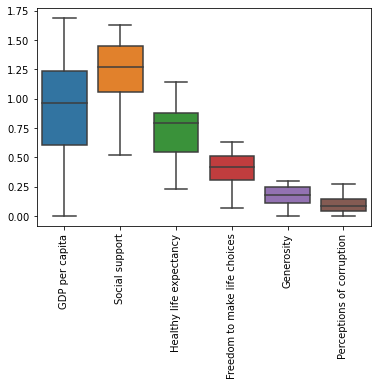

In [10]:
# Analysing the plot again we can see that outliers have been imputed
p=sns.boxplot(data=df.loc[:, ['GDP per capita', 'Social support',
                           "Healthy life expectancy",
                           "Freedom to make life choices",
                           "Generosity",
                           "Perceptions of corruption"]])

p.tick_params(axis='x', rotation=90);

In [11]:
# save country names to a list

countries=df["Country or region"].to_list()

# drop countries since they will not be used for clustering

df=df.drop("Country or region",axis=1)

#### Visaulize data to see if the scatterplot of points can be informative in determining the number of clusters

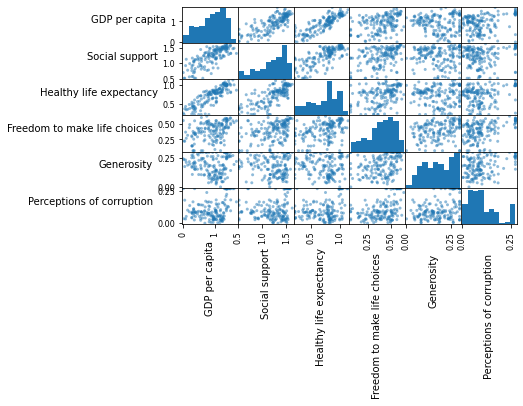

In [12]:
axes=pd.plotting.scatter_matrix(df,alpha=0.5)

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')


plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

#### Based on visualisation we can see that there is no obvious seperation of data into groups
#### Based on the plot we may want to investigate GDP per capita vs Social Support since these variables show strong positive correlation

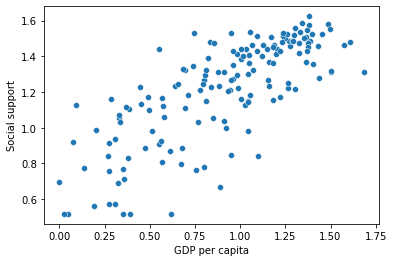

In [13]:
ax=sns.scatterplot(data=df,x="GDP per capita",y="Social support")

ax;

#### It is seems that clustering the data into 2 or 3 clusters would be best but later I will investigate this in more detail

## Correlation Matrix

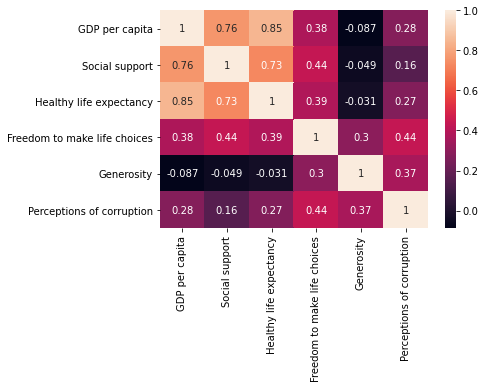

In [14]:
hm = sns.heatmap(df.corr(), annot = True)

In [15]:
df=df.drop("Healthy life expectancy",axis=1)

#### Before clustering we should first look at the scale/range of the features and decide if the features should be standardized or normalized

In [16]:
df.describe()

,GDP per capita,Social support,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,156.000000,156.000000,156.000000,156.000000
mean,0.905147,1.213981,0.393949,0.177615,0.103288
std,0.398389,0.283499,0.139811,0.079762,0.075577
min,0.000000,0.517000,0.066000,0.000000,0.000000
25%,0.602750,1.055750,0.308000,0.108750,0.047000
50%,0.960000,1.271500,0.417000,0.177500,0.085500
75%,1.232500,1.452500,0.507250,0.248250,0.141250
max,1.684000,1.624000,0.631000,0.298000,0.270000


#### We can see that features do not differ in terms of scale and that their means are quite close to each other. In this case therefore, there is no need to make any standarization or normalization

## Model

#### Visualizing cluster centers for 3 clusters

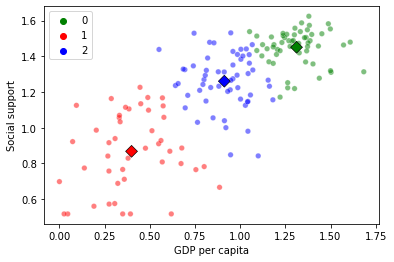

In [17]:
# Define the model and its parameters

# Let's first try with n_clusters=3. I will give the model 1000 random initializations

# fit model to data

model = KMeans(n_clusters=3,n_init=1000,random_state=100)

model.fit(df)

# predict which cluster each sample should belong to

labels=model.predict(df)

# Visualize the clusters and their centers

centroids=model.cluster_centers_

colors = ['green', 'red','blue']
ax = sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=labels, palette=colors, alpha=0.5, s=30)
ax = sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1],
                     hue=range(3), palette=colors, s=70, marker="D",ec='black', legend=False, ax=ax)
plt.show()

#### The data has been separated well into 3 clusters, but let's investigate if this is the optimal number of clusters

## Picking the best number of clusters

####  I will pick the best number of clusters based on the Elbow method but also by looking at the ratio of Between Sum of Squares to Total Sum of Squares as this is the measure of how much of the variance is explained by the model

#### Total Sum of Squares is equal to Between Sum of Squares + Within Sum of Squares. WSS can be found by calling model.inertia_

#### For BSS I will do the calculation

In [18]:
# First find the overall mean of the data

overall_mean=[]

for i in range(0,len(df.columns)):
               a=df.iloc[:,i].sum()/len(df)
               overall_mean.append(a)


# convert mean to a numpy array              
overll_mean=np.array(overall_mean)              
  
k=list(range(2,9))
inertias=[]            
ratio_bss_tss=[]


# Find TSS,BSS, BSS/TSS and inertias for different k values

for i in range(2,9):
    model = KMeans(n_clusters=i,n_init=1000,random_state=100)
    model.fit(df)
    
    inertia_rounded=round(model.inertia_,2)
    
    inertias.append(inertia_rounded)
    
    labels=model.predict(df)

    centroids=model.cluster_centers_

    # find the Euclidian distance between each cluster center and the global mean

    between_1=overall_mean-centroids
    between_2=between_1**2
    between_3=np.sum(between_2,axis=1)

     # extract the labels
     
    df["cluster"]=labels

    # find the number of observations in each cluster.    

    n_members=np.array(df["cluster"].value_counts().reset_index(name="count").sort_values("index",ascending=True).iloc[:,1])
    
    # multiply the distance of each cluster center to the global mean by the number of observations belonging to that cluster

    between_4=n_members*between_3

    # Finally calculate Between Sum of Squares
    
    BSS=np.sum(between_4)

    # Calculate Total Sum of Squares
     
    TSS=model.inertia_+BSS

    # Find the ratio     

    bss_tss=round(BSS/TSS,2)
   
    ratio_bss_tss.append(bss_tss)
    
    df=df.drop("cluster",axis=1)

In [19]:
# save inertia and BSS/TSS ratio to a DataFrame

df_k=pd.DataFrame({"k":k,
                  "inertia":inertias,
                  "ratio":ratio_bss_tss})

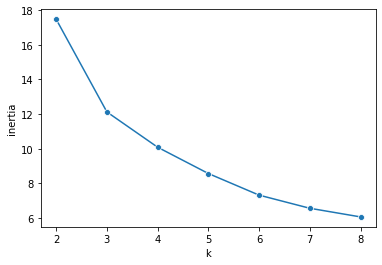

In [20]:
# Visualise the elbow plot

sns.lineplot(data=df_k,x="k",y="inertia",marker="o");

In [21]:
# Inspect BSS/TSS  
df_k

,k,inertia,ratio
0,2,17.48,0.58
1,3,12.12,0.71
2,4,10.08,0.76
3,5,8.56,0.80
4,6,7.31,0.83
5,7,6.55,0.84
6,8,6.05,0.86


#### Based on the elbow plot 3 clusters are the best option, since the slope is steepest going from 2 to 3. Also if we look at the ratio of BSS/TSS, the highest increase is happens when going from 2 to 3 clusters
#### All other changes are marginal and we know that with the addition of more clusters inertia will go down while the ratio of BSS/TSS will go up

In [22]:
# Once again run the model with optimal number of clusters and filter data based on cluster membership

model = KMeans(n_clusters=3,n_init=1000,random_state=100)
model.fit(df)
labels=model.predict(df)

df["cluster"]=labels

df["countries"]=countries

df_0=df[df["cluster"]==0]
df_1=df[df["cluster"]==1]
df_2=df[df["cluster"]==2]

#### Cluster 0 mostly consists of highly developed nations such as the ones from the EU for example



In [23]:
df_0["countries"].head()

0        Finland
1        Denmark
2         Norway
3        Iceland
4    Netherlands
Name: countries, dtype: object

#### Cluster 1 are mostly poorer nations, such as the ones in Africa and poorer Asian nations

In [24]:
df_1["countries"].head()

66      Pakistan
73    Tajikistan
88       Morocco
95      Cameroon
97         Ghana
Name: countries, dtype: object

#### Cluster 2 are developing nations such as the ones in South America or the Balkans

In [32]:
df_2["countries"].head()

11     Costa Rica
22         Mexico
26      Guatemala
31         Brazil
34    El Salvador
Name: countries, dtype: object